In [1]:
import pandas as pd
import numpy as np

Removed Neural labelling as there was high misclassification between neutral and negative, which confuses the model. And business objective is to focus on positive/negative reviews for product optimization.

In [2]:
from sklearn.model_selection import train_test_split
# 1. Load Cleaned Dataset
# ===============================
df = pd.read_csv("sephora_reviews_clean_siti.csv")

# Keep only negative (0) and positive (1) reviews
df = df[df['label'].isin([0,1])]  # remove neutral (-1)
df = df.reset_index(drop=True)

# Features and labels for modeling
X = df['text']   # only review text
y = df['label']        # 0=negative, 1=positive

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

/tmp/ipython-input-12224899.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sephora_reviews_clean_siti.csv")


In [23]:

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

custom_stopwords = list(ENGLISH_STOP_WORDS.union({
    "face","formula","product","used","new","makeup","skin","use","one","like","get",
    "this","these","those","it","its","is","are","was","were","has","have","had",
    "really","very","thing","stuff","lot","much","good","bad","okay","works","work"
}))

tfidf = TfidfVectorizer(
    ngram_range=(1,3),
    max_features=70000,
    min_df=5,
    stop_words=custom_stopwords
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Before resampling:", Counter(y_train))

Before resampling: Counter({1: 178753, 0: 20830})


In [24]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_tfidf, y_train)

print("After resampling:", Counter(y_train_res))


After resampling: Counter({1: 178753, 0: 178753})


In [25]:
lr_clf = LogisticRegression(
    max_iter=300,
    n_jobs=-1
)

lr_clf.fit(X_train_res, y_train_res)


LogisticRegression(max_iter=300, n_jobs=-1)

In [26]:
y_pred = lr_clf.predict(X_test_tfidf)

print("Logistic Regression with SMOTE")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression with SMOTE
              precision    recall  f1-score   support

           0       0.73      0.90      0.81      5207
           1       0.99      0.96      0.97     44689

    accuracy                           0.96     49896
   macro avg       0.86      0.93      0.89     49896
weighted avg       0.96      0.96      0.96     49896

Confusion Matrix:
 [[ 4662   545]
 [ 1686 43003]]


After SMOTE (balanced training set)

Class 0 (negatives):

Precision 0.74 (up from 0.60)

Recall 0.90 (similar but still strong)

F1 0.81 (big jump)

Class 1 (positives):

Precision 0.99 (same high level)

Recall 0.96 (improved vs before)

F1 0.98

Overall accuracy: 96%
Huge gain in negative review detection (precision + F1).
Balanced performance across both classes.
Much fairer model for monitoring customer sentiment.

Advanced Modeling: Hugging Face for higher accurary model evaluation


In [ ]:
# Hugging Face with DistilBert
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, ClassLabel

In [ ]:
# Prepare HF dataset
hf_dataset = Dataset.from_pandas(df[['text','label']])
hf_dataset = hf_dataset.cast_column("label", ClassLabel(num_classes=2, names=["negative","positive"]))

# Split train/test
hf_dataset = hf_dataset.train_test_split(test_size=0.2, stratify_by_column='label')
train_dataset = hf_dataset['train']
test_dataset = hf_dataset['test']

Casting the dataset:   0%|          | 0/105725 [00:00<?, ? examples/s]

In [ ]:
# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
train_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
test_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/84580 [00:00<?, ? examples/s]

Map:   0%|          | 0/21145 [00:00<?, ? examples/s]

In [ ]:
# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

from transformers import TrainingArguments
# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds)
    }


In [ ]:
from transformers import Trainer, TrainingArguments
import os

os.environ["WANDB_DISABLED"] = "true"
# Training arguments (compatible for older transformers)
training_args = TrainingArguments(
    output_dir='./hf_results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    logging_dir='./logs',
    save_total_limit=2
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()



/tmp/ipython-input-385943010.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.170200
1000,0.101500
1500,0.093900
2000,0.088500
2500,0.091200
3000,0.077100
3500,0.081300
4000,0.074800
4500,0.074600
5000,0.060200


NameError: name 'accuracy_score' is not defined

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:


# Evaluate
eval_results = trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
25,No log,0.065966,0.985528,0.991815,0.995383,0.988273


In [ ]:
print("=== Hugging Face DistilBERT Evaluation ===")
print(eval_results)

=== Hugging Face DistilBERT Evaluation ===
{'eval_loss': 0.06596562266349792, 'eval_accuracy': 0.9855284937337432, 'eval_f1': 0.9918151179585941, 'eval_precision': 0.9953827982390208, 'eval_recall': 0.988272921108742}


👉 This means:

Accuracy ~98.6% → huge jump compared to Logistic Regression (~95%).

Precision ~99.5% → very few false positives.

Recall ~98.8% → model is still catching nearly all positive reviews.

F1 ~99.2% → strong balance of precision and recall.

This confirms DistilBERT is significantly stronger than LR.

In [ ]:
# use of TF-IDF + LR
best_model = lr_clf
best_model_name = "TF-IDF + LR"
print(f"Selected model: {best_model_name}")

Selected model: TF-IDF + LR


In [ ]:
#Predict all reviews using TF-IDF LR model
X_all_tfidf = tfidf.transform(df['text'])
df['pred'] = best_model.predict(X_all_tfidf)

In [ ]:
#Product-level aggregation
product_summary = df.groupby(['pid','product_name','brand_name']).agg(
    total_reviews=('pred','count'),
    positive_reviews=('pred','sum')
).reset_index()

product_summary['positive_ratio'] = (
    product_summary['positive_reviews'] / product_summary['total_reviews']
)

# Select low-performing products: at least 30 reviews, less than 55% positive
low_perf = product_summary[
    (product_summary['total_reviews'] >= 30) &
    (product_summary['positive_ratio'] < 0.55)
].sort_values('positive_ratio')

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Expanded stopwords list (product-related + generic filler)
custom_stopwords = [
    "face","formula","product","used","new","makeup","skin","use","one","like","get",
    "this","these","those","it","its","is","are","was","were","has","have","had",
    "really","very","thing","stuff","lot","much","good","bad","okay","works","work"
]

top_neg_ngrams = {}

for idx, row in low_perf.iterrows():
    pid = row['pid']
    product_name = row['product_name'].lower()
    neg_reviews = df[(df['pid']==pid) & (df['pred']==0)]['text'].str.lower()

    if len(neg_reviews) == 0:
        continue

    # Remove product name words from reviews
    for word in product_name.split():
        neg_reviews = neg_reviews.str.replace(r'\b'+re.escape(word)+r'\b','', regex=True)

    # Vectorizer for bigrams/trigrams with TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=(2,3),   # focus on meaningful phrases
        min_df=2,            # only keep phrases appearing in ≥2 reviews
        stop_words=custom_stopwords
    )

    try:
        X_ng = vectorizer.fit_transform(neg_reviews)
    except ValueError:
        # No terms left after filtering
        continue

    if X_ng.shape[1] == 0:
        continue

    # Rank by TF-IDF mean score across docs
    scores = X_ng.mean(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    top_terms = pd.Series(scores, index=terms).sort_values(ascending=False).head(5)

    top_neg_ngrams[pid] = list(top_terms.index)

low_perf['top_negative_phrases'] = low_perf['pid'].map(top_neg_ngrams)

low_perf.to_csv("low_perf_products_selected_model5.csv", index=False)
print("Low-performing products with improved top negative phrases saved.")



Low-performing products with improved top negative phrases saved.


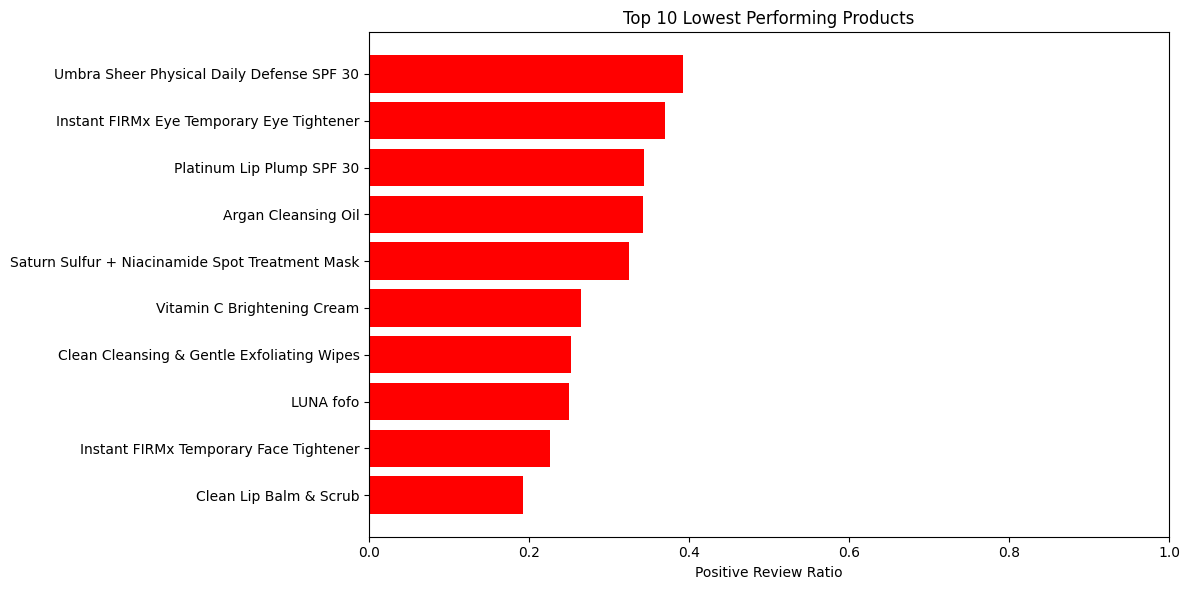

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#Bar chart for lowest performing products
plt.figure(figsize=(12,6))
top_n = 10
plot_data = low_perf.head(top_n).sort_values('positive_ratio')

plt.barh(plot_data['product_name'], plot_data['positive_ratio'], color='red')
plt.xlabel('Positive Review Ratio')
plt.title('Top 10 Lowest Performing Products')
plt.xlim(0,1)
plt.tight_layout()
plt.show()

In [ ]:
review = pd.read_csv("low_perf_products_selected_model5.csv")
print(review.head(5))

       pid                                product_name          brand_name  \
0  P460855                      Clean Lip Balm & Scrub  SEPHORA COLLECTION   
1  P271682      Instant FIRMx Temporary Face Tightener   Peter Thomas Roth   
2  P433453                                   LUNA fofo               FOREO   
3  P460723  Clean Cleansing & Gentle Exfoliating Wipes  SEPHORA COLLECTION   
4  P443841                 Vitamin C Brightening Cream      The INKEY List   

   total_reviews  positive_reviews  positive_ratio  \
0            297                57        0.191919   
1             31                 7        0.225806   
2             32                 8        0.250000   
3            254                64        0.251969   
4             83                22        0.265060   

                                top_negative_phrases  
0  ['my lips', 'your lips', 'at all', 'the old', ...  
1  ['white cast', 'leaves white', 'white film', '...  
2  ['the batteries', 'and the', 'the app'

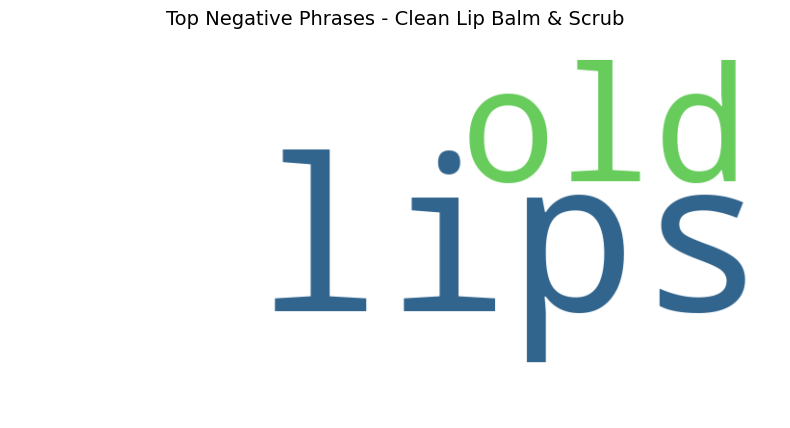

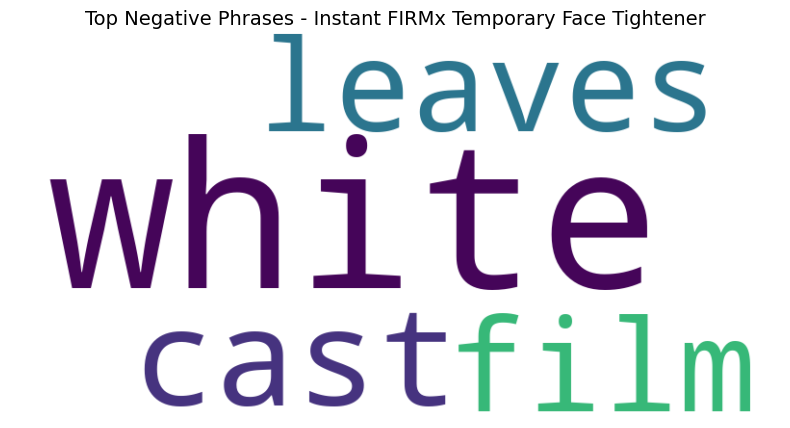

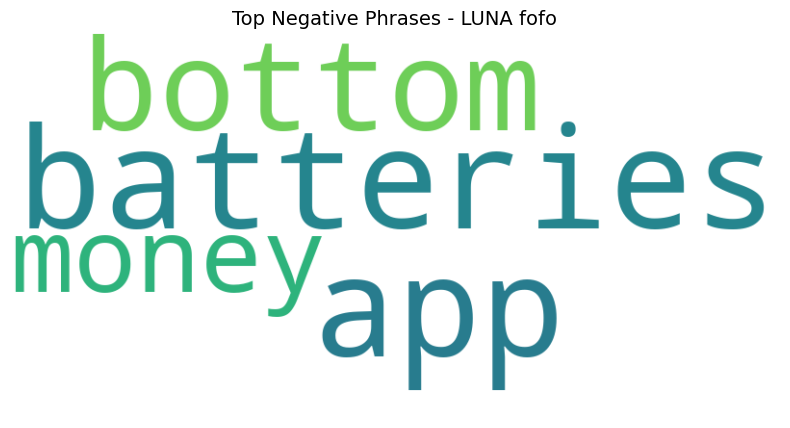

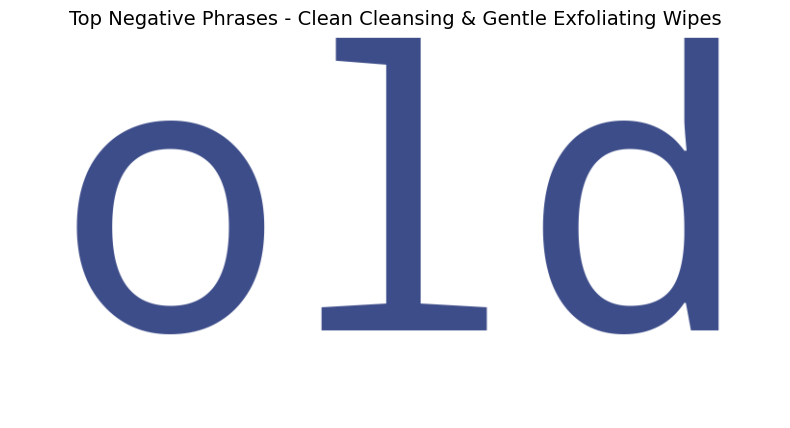

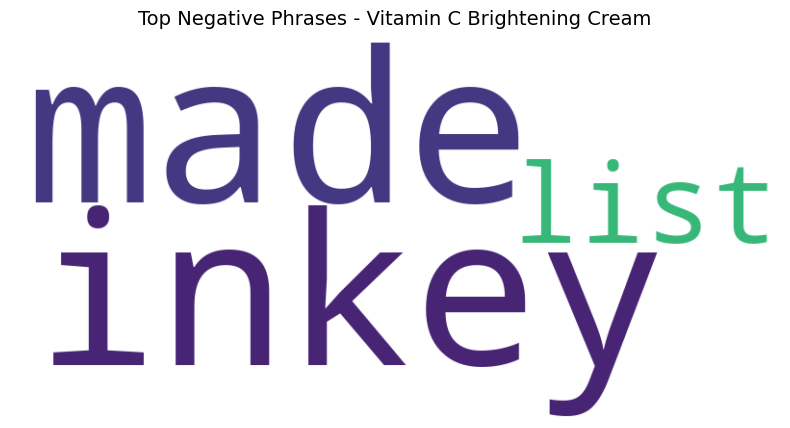

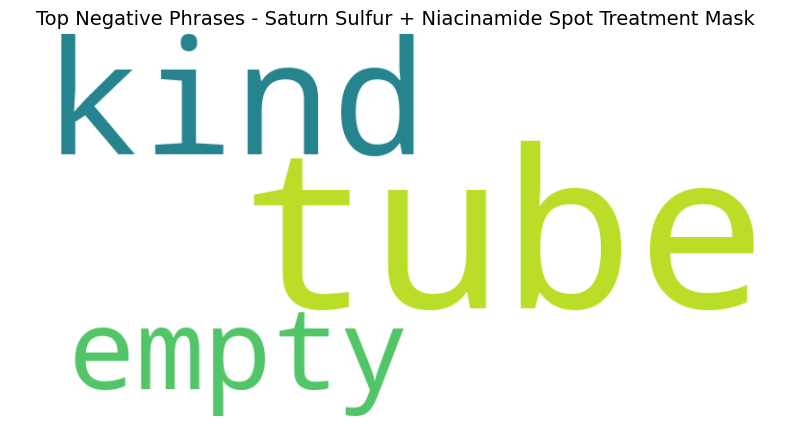

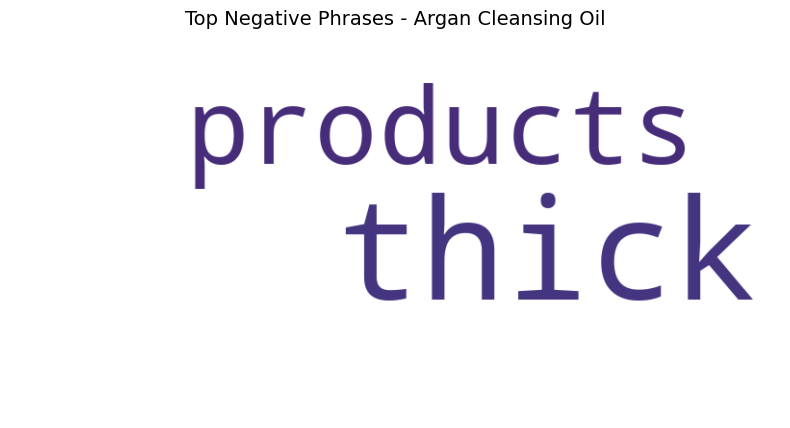

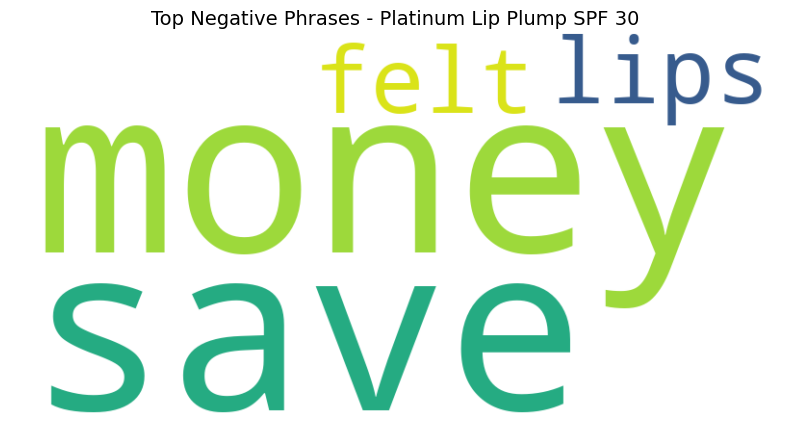

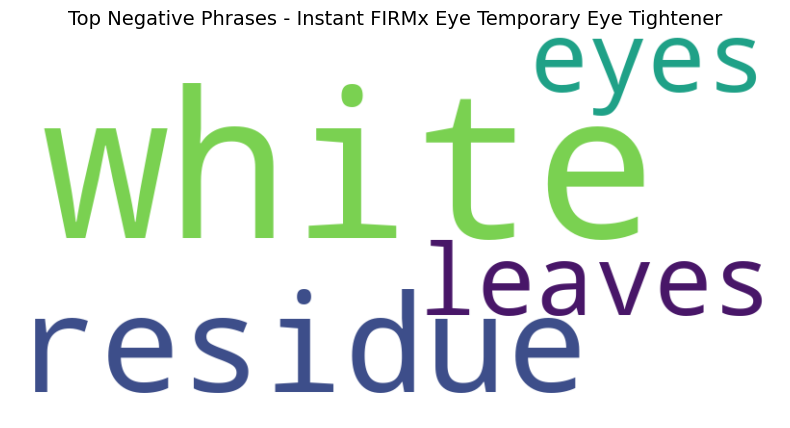

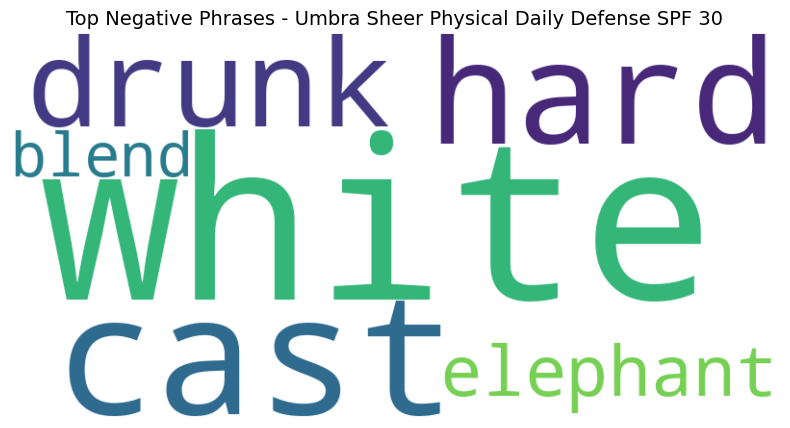

In [ ]:
# 2️⃣ Word clouds for top negative phrases
for idx, row in low_perf.head(top_n).iterrows():
    phrases = row['top_negative_phrases']
    if not phrases or len(phrases) == 0:
        continue

    text = ' '.join(phrases)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top Negative Phrases - {row['product_name']}", fontsize=14)
    plt.show()